##### In this notebook the fine tuning process used for model 04 is repeated with maximum model input lengths increased to test if this leads to a similar increase in model performance as seen with the distilbert pretrained checkpoint

# Imports

In [1]:
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, create_optimizer
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize
import random
import matplotlib.pyplot as plt

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Read in data

In [3]:
data = load_dataset(
    'csv', data_files={
        'train':'./modeling_data/training_data.csv',
        'test':'./modeling_data/testing_data.csv',
        'validation':'./modeling_data/validation_data.csv'
        }
    )

Using custom data configuration default-74d066c3e8549d77
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/default-74d066c3e8549d77/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

# Pre-process data for input to model
code from https://huggingface.co/course/chapter7/5?fw=tf


## Set up model tokenizer

In [4]:
# Using same model checkpoint as first finetuned model

model_checkpoint = "google/mt5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

## Tokenize data

In [5]:
# Increasing max input and target lengths from first model

max_input_length = 1024
max_target_length = 1024

def preprocess_function(text_data):
  model_inputs = tokenizer(
      text_data['chapter_text'], max_length=max_input_length, truncation=True
  )

  with tokenizer.as_target_tokenizer():
    labels = tokenizer(
        text_data['chapter_summary'], max_length=max_target_length, truncation=True
    )

    model_inputs['labels'] = labels['input_ids']
    return model_inputs


tokenized_data = data.map(preprocess_function)

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

# Fine tune model

## Set up model

In [6]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

All model checkpoint layers were used when initializing TFMT5ForConditionalGeneration.

All the layers of TFMT5ForConditionalGeneration were initialized from the model checkpoint at google/mt5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMT5ForConditionalGeneration for predictions without further training.


## Final processing of data for input to model

### Remove non-encoded columns from tokenized_data

In [7]:
tokenized_data_features = tokenized_data.remove_columns(
    data['train'].column_names
)

### Set up data collator to dynmaically pad inputs and labels

In [8]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors='tf')

### Use data collator to perform final processing on tokenized_data_features for input to model

In [9]:
tf_train = tokenized_data_features['train'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    collate_fn=data_collator,
    shuffle=True,
    batch_size=1
)

tf_validation = tokenized_data_features['validation'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=1
)

## Set up model hyperparamaters

In [10]:
num_train_epochs = 8
num_train_steps = len(tf_train) * num_train_epochs

optimizer, schedule = create_optimizer(
    init_lr=5.6e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
)

## Compile model

In [11]:
model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! Please ensure your labels are passed as keys in the input dict so that they are accessible to the model during the forward pass. To disable this behaviour, please pass a loss argument, or explicitly pass loss=None if you do not want your model to compute a loss.


## Fit model

In [12]:
model_history = model.fit(tf_train, validation_data=tf_validation, epochs=8)

Epoch 1/8
212/212 [==============================] - 121s 393ms/step - loss: 13.6627 - val_loss: 7.8248
Epoch 2/8
212/212 [==============================] - 75s 352ms/step - loss: 8.6475 - val_loss: 7.9230
Epoch 3/8
212/212 [==============================] - 77s 364ms/step - loss: 7.3332 - val_loss: 6.7969
Epoch 4/8
212/212 [==============================] - 77s 364ms/step - loss: 6.7621 - val_loss: 6.3975
Epoch 5/8
212/212 [==============================] - 77s 365ms/step - loss: 6.6447 - val_loss: 6.0286
Epoch 6/8
212/212 [==============================] - 77s 364ms/step - loss: 6.3826 - val_loss: 5.8080
Epoch 7/8
212/212 [==============================] - 75s 353ms/step - loss: 6.2746 - val_loss: 5.5848
Epoch 8/8
212/212 [==============================] - 75s 353ms/step - loss: 6.2180 - val_loss: 5.5123


# Visualize model 

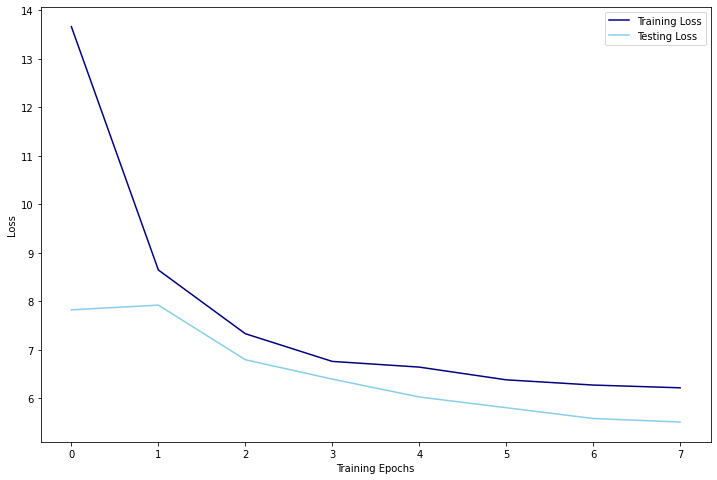

In [13]:
train_loss = model_history.history['loss']
validation_loss = model_history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training Loss', color='navy')
plt.plot(validation_loss, label='Testing Loss', color='skyblue')
plt.xlabel('Training Epochs')
plt.ylabel('Loss')
plt.legend();

The training and validation loss functions are much closer together in this modle than in the few previous, but loss is also signifcantly higher for noth datasets. The loss functions are vewry similar to those of model 4, which utilized the same base model checkpoint.

# Rouge scores for training data

In [15]:
#Get decoded predictions and labels from model
# code from https://huggingface.co/course/chapter7/5?fw=tf

train_preds = []
train_labels = []
for batch in tqdm(tf_train):
    predictions = model.generate(**batch)
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = batch["labels"].numpy()
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    train_preds.extend(decoded_preds)
    train_labels.extend(decoded_labels)

100%|██████████| 212/212 [14:38<00:00,  4.15s/it]


In [16]:
rouge = load_metric('rouge')

train_results = rouge.compute(
    predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

for key in list(train_results.keys()):
  mid_scores = train_results[key].mid
  print(key)
  print(f'precision: {mid_scores[0]*100}')
  print(f'recall: {mid_scores[1]*100}')
  print(f'f-measure: {mid_scores[2]*100}')
  print('***************')

Downloading:   0%|          | 0.00/2.16k [00:00<?, ?B/s]

rouge1
precision: 40.0
recall: 0.6430868167202572
f-measure: 1.2658227848101267
***************
rouge2
precision: 11.11111111111111
recall: 0.1610305958132045
f-measure: 0.31746031746031744
***************
rougeL
precision: 40.0
recall: 0.6430868167202572
f-measure: 1.2658227848101267
***************
rougeLsum
precision: 40.0
recall: 0.6430868167202572
f-measure: 1.2658227848101267
***************


# Rouge scores for test data

In [17]:
#Process test data for input to model

tf_test = tokenized_data_features['test'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=2
)

In [18]:
#Get decoded predictions and labels from putting test data through model
# (same process as above)

test_preds = []
test_labels = []
for batch in tqdm(tf_test):
    predictions = model.generate(**batch)
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = batch["labels"].numpy()
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    test_preds.extend(decoded_preds)
    test_labels.extend(decoded_labels)

100%|██████████| 30/30 [02:07<00:00,  4.26s/it]


In [19]:
rouge = load_metric('rouge')

test_results = rouge.compute(
    predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

for key in list(test_results.keys()):
  mid_scores = test_results[key].mid
  print(key)
  print(f'precision: {mid_scores[0]*100}')
  print(f'recall: {mid_scores[1]*100}')
  print(f'f-measure: {mid_scores[2]*100}')
  print('***************')

rouge1
precision: 56.25
recall: 3.9301310043668125
f-measure: 7.346938775510205
***************
rouge2
precision: 6.666666666666667
recall: 0.43859649122807015
f-measure: 0.823045267489712
***************
rougeL
precision: 56.25
recall: 3.9301310043668125
f-measure: 7.346938775510205
***************
rougeLsum
precision: 56.25
recall: 3.9301310043668125
f-measure: 7.346938775510205
***************


# Example model-generated summaries

In [20]:
rand_indexes = []
for i in range(3):
  rand_indexes.append(random.randint(0,59))

In [21]:
print(rand_indexes)

[25, 24, 11]


In [22]:
print(test_labels[25])

Katherine is sewing with her ladies-in-waiting.
She asks one of them to sing.
The woman sings a song about the power of music to heal sorrow.
A Gentleman enters and tells Katherine that the cardinals want to speak with her.
As Katherine asks him to show them in, she worries about what they want with her.
Wolsey and Campeius enter.
Wolsey asks her if they can speak in a private room, but she says that her conscience is clear, so she is happy to speak here.
Wolsey begins to speak to her in Latin, but she stops him, saying that it could make people think that there is something about her cause which must be hidden.
She asks him to speak in English, for all to hear.
Wolsey says that they have come not to accuse her, but to know her intentions in the matter of the divorce, and to give her advice and comfort.
Campeius says that Wolsey, out of nobility of spirit, has forgiven Katherine for her false accusations against him, and has come to offer help.
Katherine is not convinced, saying in an 

In [23]:
print(test_preds[25])

<extra_id_0>, a very a very a very a very


In [24]:
print(test_labels[24])

Darcy and Fitzwilliam leave Rosings the next morning, and Lady Catherine invites the parish party over to dine with her.
Lady Catherine tries to talk Elizabeth into staying another month, but Elizabeth is determined to soon return home as planned.
During the last week of Elizabeth and Maria's visit, they frequently are invited to Lady Catherine's, where she gives much advice on how they should travel and who should accompany them and how they should pack.
On Saturday before she leaves, Elizabeth is alone with Collins for a while, giving him the opportunity to thank her for coming, to say again how lucky they are that Lady Catherine invites them over so often, and to stress how happy he and Charlotte are.
Maria and Elizabeth leave on the chaise, and in four hours are at Mr. Gardiner's house, where they will spend a few days before they and Jane return to Longbourn.
Elizabeth finds Jane doing well, and cannot wait to tell her of Darcy's proposal, although she is not sure how much she sho

In [25]:
print(test_preds[24])

<extra_id_0> Catherine Catherine, Catherine, Catherine, Catherine, Catherine,


In [26]:
print(test_labels[11])

Healed by Virgil's forgiveness, Dante moves on with him, moving up the bank out of the Tenth Bolgia and on into the darkness.
Dante can see little, but he hears the blast of a horn and, looking toward its source, thinks he sees towers.
Virgil warns him that these shapes are not towers but giants, each standing around the edge of the deepest pit of Hell, but so huge that they tower up out of the pit.
As Dante sees them more clearly, he is filled with fear, but in fact they are no threat to him.
The first is Nimrod, who (according to the of Genesis) built the Tower of Babel in a proud and defiant attempt to reach Heaven and so caused the one language human beings had spoken up to that time to be lost.
He can only babble meaninglessly.
Next comes one of the giants who tried to unseat Jove, and he is bound.
Finally they come to Antaeus, an old antagonist of Hercules, who can speak and is not bound, and he is easily flattered into setting them down at the bottom of the pit.
Virgil holds Dan

In [27]:
print(test_preds[11])

<extra_id_0> Dante, Dante, Dante, Dante, Dante, Dante,


# Evaluation of Model

Based on rouge scores for test data, this model performed worse than the baseline model and other finetuned models. The increase in max_length parameters in the tokenizer did not lead to an increase in model performance. The example generated summaries for this model do not make human readable sense.